In [1]:
#importando bibliotecas
from sklearn.decomposition import NMF
#importando pandas para o dataset
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#biblioteca do kmeans
from sklearn.cluster import KMeans

from IPython.display import Image
from pathlib import Path


config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIR_BASE = DIR_PREFIXO / "Projeto_PA" / "dataset_modificado"
DIR_NMF = DIRETORIO_PRINCIPAL / "NMF"
DIR_KMEANS = DIRETORIO_PRINCIPAL / "KMeansRandom"

#DIRETORIO_PRINCIPAL = Path(r"D:\Projeto_PA")


In [2]:
#leitura do arquivo

#dados_mapa = pd.read_csv (DIRETORIO_PRINCIPAL / "padrao_doenca" / "pacientes_aceitos_apos_tratamento_dados.csv", sep=";", encoding="Latin1")
#dados_mapa = pd.read_csv(DIRETORIO_PRINCIPAL / "padrao_doenca" / "classificados_por_padroes_de_doenca_estatistica.csv",sep=';')

dados_mapa = pd.read_csv(DIR_BASE / "pacientes_completos_tratados.csv",sep=';', encoding="Latin1")

#dados_mapa = pd.read_csv(DIRETORIO_DATASET / "dataset_modificado" / "pacientes_com_todas_medidas.csv",sep=';')
#dados_mapa = pd.read_csv(DIRETORIO_DATASET / "dataset_modificado" / "pacientes_para_NMF.csv",sep=';', encoding="Latin1")
#dados_mapa = DIRETORIO_PRINCIPAL / "padrao_doenca" / 'idosos_classificados_por_padroes_de_doenca_estatistica.csv', 

#data = pd.read_csv(r"D:\Projeto_PA\dataset_modificado\pacientes_aceitos.csv",sep=';', encoding="Latin1")
# D:\Projeto_PA\Projeto_PA_validado\padrao_doenca


#dados_mapa = dados_mapa.drop('Unnamed: 0',axis=1)

In [3]:
#verificar nome das colunas
# print (list(dados_mapa.columns))

## Preparação do Dataset que será entrada do K-Means/NMF

In [6]:
# Separar os campos que serão utilizados
dados_mapa_original = dados_mapa

# Dataset apenas com as medidas 
dataset_medidas = pd.concat((dados_mapa.loc[:, "numero_identificacao"], dados_mapa.loc[:, "sist 9:00": "diast 8:45"]), axis=1)
# data = pd.concat((data.loc[:, "numero_identificacao"], data.loc[:, "idade"], data.loc[:, "sist 9:00": "diast 8:45"]), axis=1)


#dados_mapa = dados_mapa.drop(['data_nascimento','genero','idade','peso','altura','data_exame', 'whitecoat'],axis=1)


# Dataset com cadastro, IMC e medidas
dataset_cadastro = pd.concat([dados_mapa['numero_identificacao'],
                             dados_mapa['genero'],dados_mapa['idade'],
                             dados_mapa['IMC'],
                             dados_mapa.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com numero identificação e estatísticas
dataset_estatistica = pd.concat([dados_mapa['numero_identificacao'],
                     dados_mapa.loc[:,'Media Sistolica em 24h':'DP Diastolica em 24h']],axis=1)

# Dataset com numero identificação e doenças
dataset_doenca = pd.concat([dados_mapa['numero_identificacao'],
                     dados_mapa.loc[:,'Hipotensao':'Normotenso']],axis=1)

In [ ]:
#dados_mapa.loc[:,'Normotenso':].columns

## Matriz de Correlação das Medidas

In [ ]:
# Plotagem da Matriz de Correlação das variáveis Sistólica e Diastólica

#sistolicas = dados_mapa.loc[:, "sist 9:00": "sist 8:45"]
#correlacao_sist = sistolicas.corr(method='pearson')
#diastolicas = dados_mapa.loc[:, "diast 9:00": "diast 8:45"]
#correlacao_diast = diastolicas.corr(method='pearson')
#
#
#def grafico_correlacao(corr):
#    
#    sns.set_theme(style="white")
#
#    # Generate a mask for the upper triangle
#    mask = np.triu(np.ones_like(corr, dtype=bool))
#
#    # Set up the matplotlib figure
#    f, ax = plt.subplots(figsize=(20, 18))
#
#    # Generate a custom diverging colormap
#    cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
#    # Draw the heatmap with the mask and correct aspect ratio
#    sns.heatmap(corr, vmin=0, vmax=1, mask=mask, cmap=cmap,  center=0,
#                square=True, linewidths=.2, cbar_kws={"shrink": .8})
#    
#    plt.show()
#
#grafico_correlacao(correlacao_sist)
#grafico_correlacao(correlacao_diast)

## Tratamento de nulos

In [ ]:
#verificar a quantidade de nulos em cada linha

#medidas.isnull().sum()

#trocar Nan por 0
#medidas_sem_nan = medidas.fillna(0)

#verificando se existe nulos
#medidas_sem_nan.isnull().sum()

## K-means - identifica o melhor numero de componentes para aplicar o NMF

In [7]:
#Funções para calcular o melhor número de cluster gerado pelo Dataset


def calculate_wcss(medidas_sem_nan):
    """
    Calcula a soma dos quadrados intra-clusters para 19
    quantidades de clusters, iniciando com o mínimo de 2 clusters
    
    Parametros
    ----------
    data : DataFrame
        conjunto de dados para fazer o `.fit()` do K-Means

    
    Returns
    -------
    wcss : lista contendo os valores de soma de quadrados intra-cluster
    """
    
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n, random_state=10)
        kmeans.fit(X=medidas_sem_nan)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    """
    Calcula a maior distância entre os pontos que marcam as 
    somas dos quadrados intra-clusters para 19 calculadas 
    com `calculate_wcss()`
    
    Parametros
    ----------
    wcss : lista
        lista contendo os valores de soma de quadrados intra-cluster

    
    Returns
    -------
    int : número de clusters 
    """
    from math import sqrt
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2

In [8]:
def verdadeiro_falso(valor):
    if valor == True:
        return 1
    else:
        return 0

In [9]:
genero_M_F = {"genero": {1: "M", 0: "F"}}

## Abordagem 1: Medidas

In [10]:
#  Excluindo a variavel numero de identificação para entrada do NMF

medidas_sem_id = dataset_medidas.drop(['numero_identificacao'],axis=1)

### K-Means

In [11]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
sum_of_squares = calculate_wcss(medidas_sem_id)
numero_otimo_cluster_medidas = optimal_number_of_clusters(sum_of_squares)
print (numero_otimo_cluster_medidas)

7


In [12]:
#   convertendo os dados para a clusterização
#   converte de DataFrame para Array por causa do K-Means
medidas_sem_id_array = np.array(medidas_sem_id)

In [13]:
#habilitando o kmeans com numero otimo de grupos (calculado na etapa anterior)
kmeans_medidas = KMeans(n_clusters=numero_otimo_cluster_medidas, random_state=10).fit(medidas_sem_id_array)

In [14]:
#grupo 0 tem 4968 pacientes
#mapa_grupos[mapa_grupos['grupo']==0]

In [15]:
#grupo 1 tem 2063 pacientes
#mapa_grupos[mapa_grupos['grupo']==1]

In [16]:
#grupo 2 tem 1963 pacientes
#mapa_grupos[mapa_grupos['grupo']==2]

In [17]:
#grupo 3 tem 3370 pacientes
#mapa_grupos[mapa_grupos['grupo']==3]

In [18]:
#grupo 4 tem 2788 pacientes
#mapa_grupos[mapa_grupos['grupo']==4]

In [19]:
#grupo 5 tem 3397 pacientes
#mapa_grupos[mapa_grupos['grupo']==5]

In [20]:
#grupo 6 tem 2391 pacientes
#mapa_grupos[mapa_grupos['grupo']==6]

In [21]:
#grupo 7 tem 2391 pacientes
#mapa_grupos[mapa_grupos['grupo']==7]

In [22]:
#grupo 8 tem 2391 pacientes
#mapa_grupos[mapa_grupos['grupo']==8]

## Nonnegative Matrix Factorization 

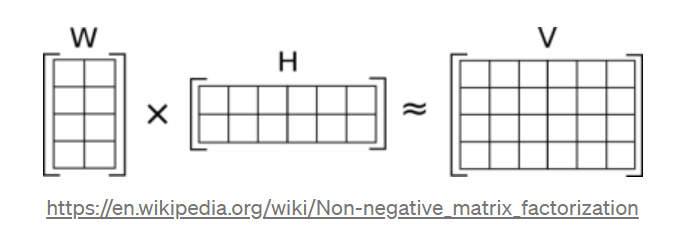

In [23]:
Image(filename=r"C:\Users\marta\projeto_pa\NMF\imgs\Imagem1.png")

### O objetivo no NMF é decompor a matriz (V) pelo produto escalar de dois arrays W e H. As dimensões dos arrays são definidas pelas dimensões de V (valores do paciente) e pelo número de componentes que definimos para o algoritmo. Se V tem n linhas e x colunas e queremos decompor em k componentes, então W tem n linhas e k colunas e H tem k linhas e x colunas.

In [24]:
#aplicando o NMF com numero de componente = numero_otimo_cluster calculado pelo K-means
model_medidas = NMF(n_components=numero_otimo_cluster_medidas,init='random',random_state=0)


In [25]:
#   aplicando o modelo NMF
model_medidas.fit(medidas_sem_id)


NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0, max_iter=200,
    n_components=7, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [26]:
medidas_sem_id

,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
0,105.0,108.0,116.0,104.0,106.0,98.0,102.0,107.0,111.0,116.0,...,41.0,46.0,51.0,56.0,61.0,67.0,61.0,69.0,62.0,51.0
1,103.0,114.0,82.0,104.0,98.0,106.0,108.0,107.0,109.0,100.0,...,74.0,74.0,74.0,70.0,67.0,63.0,60.0,74.0,70.0,67.0
2,147.0,148.0,156.0,140.0,130.0,132.0,121.0,113.0,149.0,128.0,...,80.0,86.0,93.0,91.0,89.0,87.0,86.0,87.0,82.0,82.0
3,140.0,139.0,142.0,137.0,135.0,177.0,148.0,152.0,135.0,136.0,...,49.0,56.0,62.0,83.0,104.0,99.0,94.0,89.0,90.0,72.0
4,113.0,110.0,101.0,108.0,111.0,111.0,114.0,115.0,113.0,112.0,...,64.0,73.0,83.0,93.0,68.0,91.0,87.0,84.0,81.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19237,163.0,198.0,172.0,148.0,161.0,156.0,156.0,138.0,107.0,76.0,...,102.0,114.0,126.0,125.0,124.0,123.0,123.0,121.0,119.0,123.0
19238,114.0,120.0,164.0,116.0,119.0,126.0,123.0,122.0,122.0,159.0,...,87.0,73.0,59.0,74.0,68.0,86.0,96.0,107.0,106.0,93.0
19239,107.0,110.0,103.0,105.0,108.0,111.0,114.0,144.0,128.0,104.0,...,49.0,50.0,50.0,53.0,52.0,62.0,68.0,61.0,64.0,60.0
19240,94.0,107.0,112.0,124.0,120.0,94.0,102.0,113.0,104.0,96.0,...,63.0,63.0,64.0,76.0,72.0,69.0,75.0,74.0,69.0,67.0


In [27]:
#  'Grupo x' sendo x = numero_otimo_cluster

#Criando H como resultado do produto escalar das matrizes
H_medidas = pd.DataFrame(np.round(model_medidas.components_,3), columns=medidas_sem_id.columns)

H_medidas.index = [f'Grupo {i + 1}' for i in range(numero_otimo_cluster_medidas)]



In [28]:
#Foi criado "numero_otimo_cluster" grupos
H_medidas

,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
Grupo 1,6.999,7.300,7.488,7.658,7.637,7.730,7.625,7.598,7.441,7.348,...,0.972,1.118,1.242,1.469,1.645,1.850,2.042,2.232,2.383,2.612
Grupo 2,2.358,1.928,1.523,1.189,0.845,0.436,0.222,0.000,0.000,0.000,...,3.730,3.741,3.768,3.771,3.798,3.724,3.771,3.758,3.704,3.565
Grupo 3,0.646,0.482,0.480,0.531,0.749,1.115,1.459,1.762,2.027,2.340,...,5.598,5.190,4.775,4.105,3.500,2.985,2.335,1.861,1.486,1.116
Grupo 4,0.398,0.483,0.792,1.313,1.918,2.529,3.277,3.915,4.520,5.004,...,0.767,0.839,0.899,0.875,0.746,0.505,0.318,0.143,0.089,0.012
Grupo 5,8.610,8.262,7.826,7.351,6.842,6.215,5.566,4.895,4.401,3.792,...,3.197,3.697,4.142,4.621,4.948,5.240,5.374,5.374,5.345,5.281
Grupo 6,3.117,3.672,4.069,4.293,4.601,4.718,4.810,4.886,4.781,4.696,...,2.326,2.352,2.406,2.530,2.872,3.248,3.663,4.064,4.379,4.711
Grupo 7,4.379,4.359,4.253,3.914,3.636,3.351,3.119,2.972,2.790,2.714,...,0.304,0.101,0.000,0.000,0.000,0.084,0.222,0.348,0.417,0.464


In [30]:
#Calcula a soma total por grupos
#lista = []
#for k in range(0,numero_otimo_cluster):
#    sum_ = 0
#    for i in H.columns:
#        sum_ = sum_ + H.iloc[[k]][i]
#    lista.append(sum_)

In [ ]:
#lista[0]
#np.sum(H.iloc[0,:].values)

In [ ]:
#o grupo com maior soma total é Grupo 6
#lista

##### O grupo 5 é o que tem a maior soma total dos valores entre sist e diast, mesmo que grupo 2 tenha os maiores valores por variavel (sist) ele que tem a menor somar total


In [ ]:
#Salvar a planilha
#H.to_excel('H.xlsx')

#H.to_csv(DIR_NMF / "H.csv", sep=";", encoding="Latin1")


#H.to_csv(r"C:\Users\marta\projeto_pa\NMF\H.csv", sep=";", encoding="Latin1")


In [31]:
#Gera o W com numero do paciente, para verificar a importancia que cada paciente tem em cada grupo
#W = pd.DataFrame(np.round(model.transform(dados_sem_id),2), columns=H.index)
#W.index = dados_mapa["numero_identificacao"]
W_medidas = pd.DataFrame(np.round(model_medidas.transform(medidas_sem_id),3), columns=H_medidas.index)

#  Incluir o numero_identificacao na matriz W

#W_medidas = pd.concat([dados_mapa["numero_identificacao"],W_medidas],axis=1)

#exemplo o paciente 5 não tem muita influencia no Grupo 7, está presenta mais no Grupo 1
#print(len(dados_mapa), len(dados_mapa_original))
W_medidas

,Grupo 1,Grupo 2,Grupo 3,Grupo 4,Grupo 5,Grupo 6,Grupo 7
0,6.318,1.902,3.221,6.134,1.978,2.302,5.615
1,7.081,5.070,5.362,2.720,2.488,1.313,3.008
2,8.885,5.344,2.335,2.361,3.731,3.642,5.952
3,9.638,4.445,2.985,3.098,4.677,4.175,3.913
4,6.840,6.116,3.156,4.626,3.093,3.555,2.088
...,...,...,...,...,...,...,...
19237,8.487,9.894,6.469,5.096,5.858,5.794,0.306
19238,8.622,4.508,5.336,5.370,2.955,4.343,3.254
19239,8.139,2.763,2.878,4.818,1.939,2.491,4.256
19240,5.189,6.044,2.635,5.247,4.159,2.057,2.922


#### No vetor W é possivel identificar a importancia dos dados dos pacientes para criação do grupo, como pode ser visto o Paciente 4 que não tem relação com o grupo 1, mas participar do grupo 2 e 3.

In [32]:
#W.to_excel('W.xlsx')
#W_medidas.to_csv(DIR_NMF / "W.csv", sep=";", encoding="Latin1")


#W.to_csv(r"C:\Users\marta\projeto_pa\NMF\W.csv", sep=";", encoding="Latin1")


In [33]:
# Calcula a relevância de cada linha comparando os valores de cada grupo totalizando 1

def relevancia_comparada(matriz_W):
    for linha in range(len(matriz_W)):
        soma_grupos = np.sum(matriz_W.iloc[linha,:])
        for coluna in range(len(matriz_W.iloc[linha,:])):
            matriz_W.iloc[linha,coluna] = matriz_W.iloc[linha,coluna]/soma_grupos
    return matriz_W

In [34]:
valores_relevancia_medidas = relevancia_comparada(W_medidas)

In [35]:
valores_relevancia_medidas

,Grupo 1,Grupo 2,Grupo 3,Grupo 4,Grupo 5,Grupo 6,Grupo 7
0,0.229996,0.069239,0.117255,0.223298,0.072006,0.083801,0.204405
1,0.261852,0.187486,0.198284,0.100584,0.092005,0.048554,0.111234
2,0.275504,0.165705,0.072403,0.073209,0.115690,0.112930,0.184558
3,0.292673,0.134979,0.090644,0.094075,0.142024,0.126780,0.118824
4,0.232069,0.207505,0.107077,0.156952,0.104940,0.120615,0.070842
...,...,...,...,...,...,...,...
19237,0.202534,0.236111,0.154377,0.121611,0.139796,0.138268,0.007302
19238,0.250727,0.131092,0.155170,0.156159,0.085931,0.126294,0.094626
19239,0.298307,0.101268,0.105483,0.176587,0.071067,0.091299,0.155989
19240,0.183662,0.213924,0.093264,0.185715,0.147206,0.072806,0.103423


In [36]:

#função para padronizar os grupos
#def padronizar_grupos(colunas_de_W):
#    lista_final = []
#    
#    for itm in colunas_de_W:
#        rst = float(float(itm)/float(sum(colunas_de_W)))
#        lista_final.append(rst)
#    
#    return lista_final
#
##criando o dataframe W padronizado
#W_padronizado = pd.DataFrame()
#
#for col in W.columns:
#    W_padronizado[col] = padronizar_grupos(W[col])
#
#W_padronizado['numero_identificacao'] = dados_mapa['numero_identificacao']
#
## Grava W_padronizado
#W_padronizado.to_csv(DIR_NMF / "W_padronizado.csv", sep=";", encoding="Latin1")

#W_padronizado.to_csv(r"C:\Users\marta\projeto_pa\NMF\W_padronizado.csv", sep=";", encoding="Latin1")

In [38]:
#Lista os maiores valores de cada grupo
#mostra_maiores_valores = []
#
#for col in W.columns:
#    valor = list(W_padronizado[W_padronizado[col] == max(W_padronizado[col])]['numero_identificacao'])[0]
#    mostra_maiores_valores.append(valor)
#
#W_padronizado[W_padronizado['numero_identificacao'].isin(mostra_maiores_valores)]

def encontra_maior(matriz_W):
    grupo = list()
    for linha in range(len(matriz_W)):
        maior = max(matriz_W.iloc[linha,:])
        for coluna in range(len(matriz_W.iloc[linha,:])):
            if matriz_W.iloc[linha,coluna] == maior:
                grupo.append(coluna + 1)
                break
    matriz_W['grupo'] = grupo
    return matriz_W

valores_relevancia_medidas = encontra_maior(valores_relevancia_medidas)
valores_relevancia_medidas

,Grupo 1,Grupo 2,Grupo 3,Grupo 4,Grupo 5,Grupo 6,Grupo 7,grupo
0,0.229996,0.069239,0.117255,0.223298,0.072006,0.083801,0.204405,1
1,0.261852,0.187486,0.198284,0.100584,0.092005,0.048554,0.111234,1
2,0.275504,0.165705,0.072403,0.073209,0.115690,0.112930,0.184558,1
3,0.292673,0.134979,0.090644,0.094075,0.142024,0.126780,0.118824,1
4,0.232069,0.207505,0.107077,0.156952,0.104940,0.120615,0.070842,1
...,...,...,...,...,...,...,...,...
19237,0.202534,0.236111,0.154377,0.121611,0.139796,0.138268,0.007302,2
19238,0.250727,0.131092,0.155170,0.156159,0.085931,0.126294,0.094626,1
19239,0.298307,0.101268,0.105483,0.176587,0.071067,0.091299,0.155989,1
19240,0.183662,0.213924,0.093264,0.185715,0.147206,0.072806,0.103423,2


In [ ]:
# Gera dataset resultante do NMF com dados cadastrais de cada paciente, medidas e seu peso em cada grupo

todos_os_dados = metadados = dados_mapa_original.copy()
metadados.index = metadados["numero_identificacao"]

mapa_cadastro_grupos = pd.concat([metadados["genero"] , metadados["idade"], 
                         metadados["peso"], metadados["data_exame"],
                        W], axis=1)

saida_NMF = pd.concat ([metadados["genero"] , metadados["idade"], 
                         metadados["peso"], metadados["data_exame"], 
                        metadados.loc[:,"sist 9:00": "diast 8:45"],
                        W], axis=1)
#
#mapa_grupos = W.copy()
#
#for coluna in reversed(["genero", "idade", "peso", "data_exame"]):
#    mapa_grupos.insert(0, coluna, metadados[coluna])
#
#mapa_grupos

saida_NMF

In [ ]:


# Gera dataset resultante do NMF com dados cadastrais de cada paciente, medidas e seu peso em cada grupo

todos_os_dados = metadados = dados_mapa_original.copy()
metadados.index = metadados["numero_identificacao"]

mapa_cadastro_grupos_estatistica = pd.concat([metadados.loc[:,"genero":"DP Diastolica em 24h"],
                        W_estatistica], axis=1)


## Abordagem 2: Cadastro

### K-means 

In [ ]:
dataset_cadastro_sem_id = dataset_cadastro.drop (['numero_identificacao'], axis=1) 
dataset_cadastro_sem_id_array = np.array (dataset_cadastro_sem_id)

#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
sum_of_squares = calculate_wcss(dataset_cadastro_sem_id_array)
numero_otimo_cluster_cadastro = optimal_number_of_clusters(sum_of_squares)
print (numero_otimo_cluster_cadastro)


In [ ]:
kmeans_cadastro = KMeans(n_clusters=numero_otimo_cluster_cadastro, random_state=10).fit(dataset_cadastro_sem_id_array)

In [ ]:
grupos_cadastro = kmeans.fit_predict(dataset_cadastro_sem_id_array)

In [ ]:
#  Inclui o grupo de cada paciente no dataset de entrada
mapa_grupos_cadastro = dados_mapa.loc[:,:'data_exame']
mapa_grupos_cadastro['grupo'] = grupos_cadastro
mapa_grupos_cadastro = pd.concat([mapa_grupo_cadastro,dados_mapa.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
mapa_grupos_cadastro

In [ ]:
#aplicando o NMF com numero de componente = numero_otimo_cluster calculado pelo K-means
model_cadastro = NMF(n_components=numero_otimo_cluster_cadastro,init='random',random_state=0)

In [ ]:
#   aplicando o modelo NMF
model_cadastro.fit(dataset_cadastro_sem_id_array)

In [ ]:
#  'Grupo x' sendo x = numero_otimo_cluster

#Criando H como resultado do produto escalar das matrizes
H_cadastro = pd.DataFrame(np.round(model_cadastro.components_,2), columns=dataset_cadastro_sem_id.columns)

H_cadastro.index = [f'Grupo {i + 1}' for i in range(numero_otimo_cluster_cadastro)]



In [ ]:
#Calcula a soma total por grupos
lista = []
for k in range(0,numero_otimo_cluster_cadastro):
    sum_ = 0
    for i in H_cadastro.columns:
        sum_ = sum_ + H_cadastro.iloc[[k]][i]
    lista.append(sum_)

In [ ]:
lista[0]
np.sum(H_cadastro.iloc[0,:].values)

In [ ]:
#o grupo com maior soma total é Grupo 6
lista

##### O grupo 5 é o que tem a maior soma total dos valores entre sist e diast, mesmo que grupo 2 tenha os maiores valores por variavel (sist) ele que tem a menor somar total


In [ ]:
#Gera o W com numero do paciente, para verificar a importancia que cada paciente tem em cada grupo
#W = pd.DataFrame(np.round(model.transform(dados_sem_id),2), columns=H.index)
#W.index = dados_mapa["numero_identificacao"]
W_cadastro = pd.DataFrame(np.round(model_cadastro.transform(dados_sem_id),3), columns=H_cadastro.index)

#  Incluir o numero_identificacao na matriz W
numero_id = dados_mapa["numero_identificacao"]
W_cadastro = pd.concat([numero_id,W_cadastro],axis=1)

#exemplo o paciente 5 não tem muita influencia no Grupo 7, está presenta mais no Grupo 1
#print(len(dados_mapa), len(dados_mapa_original))
W_cadastro

#### No vetor W é possivel identificar a importancia dos dados dos pacientes para criação do grupo, como pode ser visto o Paciente 4 que não tem relação com o grupo 1, mas participar do grupo 2 e 3.

In [ ]:
# Calcula a relevância de cada linha comparando os valores de cada grupo totalizando 1

def relevancia_comparada(matriz_W):
    for linha in range(len(matriz_W)):
        soma_grupos = np.sum(matriz_W.iloc[linha,1:])
        for coluna in range(1,len(matriz_W.iloc[linha,1:]) + 1):
            matriz_W.iloc[linha,coluna] = matriz_W.iloc[linha,coluna]/soma_grupos
    return matriz_W

In [ ]:
valores_relevancia_cadastro = relevancia_comparada(W_cadastro)

In [ ]:
valores_relevancia_cadastro

In [ ]:

#função para padronizar os grupos
#def padronizar_grupos(colunas_de_W):
#    lista_final = []
#    
#    for itm in colunas_de_W:
#        rst = float(float(itm)/float(sum(colunas_de_W)))
#        lista_final.append(rst)
#    
#    return lista_final
#
##criando o dataframe W padronizado
#W_padronizado = pd.DataFrame()
#
#for col in W.columns:
#    W_padronizado[col] = padronizar_grupos(W[col])
#
#W_padronizado['numero_identificacao'] = dados_mapa['numero_identificacao']
#
## Grava W_padronizado
#W_padronizado.to_csv(DIR_NMF / "W_padronizado.csv", sep=";", encoding="Latin1")

#W_padronizado.to_csv(r"C:\Users\marta\projeto_pa\NMF\W_padronizado.csv", sep=";", encoding="Latin1")

In [ ]:
#Lista os maiores valores de cada grupo
#mostra_maiores_valores = []
#
#for col in W.columns:
#    valor = list(W_padronizado[W_padronizado[col] == max(W_padronizado[col])]['numero_identificacao'])[0]
#    mostra_maiores_valores.append(valor)
#
#W_padronizado[W_padronizado['numero_identificacao'].isin(mostra_maiores_valores)]

In [ ]:
# Gera dataset resultante do NMF com dados cadastrais de cada paciente, medidas e seu peso em cada grupo

todos_os_dados = metadados = dados_mapa_original.copy()
metadados.index = metadados["numero_identificacao"]

mapa_cadastro_grupos = pd.concat([metadados["genero"] , metadados["idade"], 
                         metadados["peso"], metadados["data_exame"],
                        W], axis=1)

saida_NMF_cadastro = pd.concat([metadados["genero"] , metadados["idade"], 
                         metadados["peso"], metadados["data_exame"], 
                        metadados.loc[:,"sist 9:00": "diast 8:45"],
                        W], axis=1)
#
#mapa_grupos = W.copy()
#
#for coluna in reversed(["genero", "idade", "peso", "data_exame"]):
#    mapa_grupos.insert(0, coluna, metadados[coluna])
#
#mapa_grupos

saida_NMF

In [ ]:


# Gera dataset resultante do NMF com dados cadastrais de cada paciente, medidas e seu peso em cada grupo

todos_os_dados = metadados = dados_mapa_original.copy()
metadados.index = metadados["numero_identificacao"]

mapa_cadastro_grupos_estatistica = pd.concat([metadados.loc[:,"genero":"DP Diastolica em 24h"],
                        W_estatistica], axis=1)


In [ ]:
#convertendo os dados para a clusterização
X = np.array(dados_cadastro_sem_id)

In [ ]:
#habilitando o kmeans com 8 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=num_otimo_clusters, random_state=42).fit(X)

In [ ]:
#listar os grupos 
grupos = kmeans.fit_predict(X)

In [ ]:
#incluir grupos nos dados de sist e diast
dados_cadastro_sem_id['grupo'] = grupos
dados_cadastro_sem_id['grupo'] = dados_cadastro_sem_id['grupo'] + 1
dados_cadastro_sem_id


## Abordagem 2: Estatística

In [ ]:
#estatistica = pd.concat((dados_mapa.loc[:, "numero_identificacao"], dados_mapa.loc[:, "Media Sistolica em 24h": "DP Diastolica em 24h"]), axis=1)
#estatistica = estatistica.drop(['Media Sistolica Vespertina','Media Diastolica Vespertina','Media Sistolica Matutina',
#                               'Media Diastolica Matutina','Media Diastolica Diurna','Media Sistolica Diurna'],axis=1)

estatistica = dados_mapa.loc[:, "AUC Sistolica em 24h": "AUC PP Nighttime"]
estatistica = pd.concat([dados_mapa.loc[:, "numero_identificacao"], estatistica], axis=1)
estatistica

estatistica_sem_id = estatistica.drop(['numero_identificacao'],axis=1)

In [ ]:

estatistica_sem_id = estatistica.drop(['numero_identificacao'],axis=1)

In [ ]:
estatistica_sem_id

In [ ]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
estatistica_sem_id = estatistica_sem_id.fillna(0)
sum_of_squares_estatistica = calculate_wcss(estatistica_sem_id)
numero_otimo_cluster_estatistica = optimal_number_of_clusters(sum_of_squares_estatistica)
print (numero_otimo_cluster_estatistica)

In [ ]:
#   convertendo os dados para a clusterização
#   converte de DataFrame para Array por causa do K-Means
X = np.array(dados_sem_id)

In [ ]:
#   convertendo os dados para a clusterização
#   converte de DataFrame para Array por causa do K-Means
estatistica_forma = np.array(estatistica_sem_id)

In [ ]:
#habilitando o kmeans com numero otimo de grupos (calculado na etapa anterior)
kmeans = KMeans(n_clusters=numero_otimo_cluster, random_state=10).fit(X)

In [ ]:
#habilitando o kmeans com numero otimo de grupos (calculado na etapa anterior)
kmeans_estatistica = KMeans(n_clusters=numero_otimo_cluster_estatistica, random_state=10).fit(estatistica_forma)

In [ ]:
# Gera os números dos grupos 
# 
grupos = kmeans.fit_predict(X)

In [ ]:
# Gera os números dos grupos 
# 
grupos_estatistica = kmeans_estatistica.fit_predict(estatistica_forma)

In [ ]:
#aplicando o NMF com numero de componente = numero_otimo_cluster calculado pelo K-means
#aplicando o NMF com numero de componente = numero_otimo_cluster calculado pelo K-means
model_estatistica = NMF(n_components=numero_otimo_cluster_estatistica,init='random',random_state=0)

In [ ]:
#  Inclui o grupo de cada paciente no dataset de entrada
mapa_grupos = dados_mapa.loc[:,:'data_exame']
mapa_grupos['grupo'] = grupos
mapa_grupos = pd.concat([mapa_grupos,dados_mapa.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
mapa_grupos

## n Grupos de pacientes separados pelo Kmeans, sendo n=número ótimo de clusters

In [ ]:
#  Inclui o grupo de cada paciente no dataset de entrada
mapa_grupos_estatistica = dados_mapa.loc[:,:'data_exame']
mapa_grupos_estatistica['grupo'] = grupos_estatistica
mapa_grupos_estatistica = pd.concat([mapa_grupos_estatistica,dados_mapa.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
mapa_grupos_estatistica

In [ ]:

#   aplicando o modelo NMF
model_estatistica.fit(estatistica_sem_id)

In [ ]:
estatistica
#  'Grupo x' sendo x = numero_otimo_cluster

#Criando H como resultado do produto escalar das matrizes
H_estatistica = pd.DataFrame(np.round(model_estatistica.components_,2), columns=estatistica_sem_id.columns)

H_estatistica.index = [f'Grupo {i + 1}' for i in range(numero_otimo_cluster_estatistica)]

In [ ]:
 

#Gera o W com numero do paciente, para verificar a importancia que cada paciente tem em cada grupo
#W = pd.DataFrame(np.round(model.transform(dados_sem_id),2), columns=H.index)
#W.index = dados_mapa["numero_identificacao"]
W_estatistica = pd.DataFrame(np.round(model_estatistica.transform(estatistica_sem_id),3), columns=H_estatistica.index)

#  Incluir o numero_identificacao na matriz W
numero_id_estatistica = dados_mapa["numero_identificacao"]
W_estatistica = pd.concat([numero_id_estatistica,W_estatistica],axis=1)

#exemplo o paciente 5 não tem muita influencia no Grupo 7, está presenta mais no Grupo 1
#print(len(dados_mapa), len(dados_mapa_original))
W_estatistica

In [ ]:

valores_relevancia_estatistica = relevancia_comparada(W_estatistica)


In [ ]:
valores_relevancia_estatistica

##  Gera dataset separados por cada grupo contendo todos os dados 

In [ ]:
#mapa_grupos[mapa_grupos['grupo'] == 0]['grupo'].unique()
grupo = []
for linha in range(len(valores_relevancia)):
    maximo = max(valores_relevancia.iloc[linha,1:])
    for coluna in range(1, len(valores_relevancia.iloc[linha,1:]) + 1):
        if valores_relevancia.iloc[linha,coluna] == maximo:
            grupo.append(coluna)
            break

In [ ]:
valores_relevancia_estatistica

In [ ]:
#mapa_grupos[mapa_grupos['grupo'] == 0]['grupo'].unique()
grupo_estatistica = []
for linha in range(len(valores_relevancia_estatistica)):
    maximo = max(valores_relevancia_estatistica.iloc[linha,1:])
    for coluna in range(1, len(valores_relevancia_estatistica.iloc[linha,1:]) + 1):
        if valores_relevancia_estatistica.iloc[linha,coluna] == maximo:
            grupo_estatistica.append(coluna)
            break

In [ ]:
valores_relevancia_grupo = pd.DataFrame()
valores_relevancia_grupo['numero_identificacao'] = valores_relevancia['numero_identificacao']
valores_relevancia_grupo['grupo'] = grupo
valores_relevancia_grupo = pd.concat([valores_relevancia_grupo,valores_relevancia.loc[:,'Grupo 1':]],axis=1)
valores_relevancia_grupo.to_csv(DIR_NMF / "NMF_pacientes_por_grupo" /  "valores_relevancia_grupo.csv", sep=";", encoding="latin1",index=False)
valores_relevancia_grupo

In [ ]:

valores_relevancia_grupo_estatistica = pd.DataFrame()
valores_relevancia_grupo_estatistica['numero_identificacao'] = valores_relevancia_estatistica['numero_identificacao']
valores_relevancia_grupo_estatistica['grupo'] = grupo_estatistica
valores_relevancia_grupo_estatistica = pd.concat([valores_relevancia_grupo_estatistica,valores_relevancia_estatistica.loc[:,'Grupo 1':]],axis=1)
valores_relevancia_grupo_estatistica.to_csv(DIR_NMF / "NMF_pacientes_por_grupo" /  "valores_relevancia_grupo_estatistica.csv", sep=";", encoding="latin1",index=False)
valores_relevancia_grupo_estatistica

In [ ]:
set(grupo_estatistica)

In [ ]:
todos_dados_grupo = pd.concat([dados_mapa.loc[:,:'data_exame'],
                               valores_relevancia_grupo['grupo'],
                               dados_mapa.loc[:,'sist 9:00':]],axis=1)
todos_dados_grupo

In [ ]:
estatistica
todos_dados_grupo_estatistica = pd.concat([dados_mapa.loc[:,:'data_exame'],
                               valores_relevancia_grupo_estatistica['grupo'],
                               dados_mapa.loc[:,'sist 9:00':]],axis=1)
todos_dados_grupo_estatistica

In [ ]:
def gera_arquivos_por_grupo(todos_dados_grupo,abordagem):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_NMF / f"NMF_approach_{abordagem}_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=True)

In [ ]:
gera_arquivos_por_grupo(todos_dados_grupo,'medidas')

In [ ]:

gera_arquivos_por_grupo(todos_dados_grupo_estatistica,'estatistica')

In [ ]:
set(todos_dados_grupo_estatistica["grupo"])

In [ ]:
#      Plota os gráficos de cada grupo resultado do NMF

#   Transpose apenas para facilitar a montagem do grafico. As colunas se tornam linhas e vice-versa
#df = pd.read_csv(DIR_NMF / "H.csv", delimiter=';', index_col=0).T

df = H.T
# prepara os dados para filtrar o que é Sistólica e o que é Diastólica
df['is_sist'] = ['sist' in i for i in df.index.values]
df['is_diast'] = ['diast' in i for i in df.index.values]

# divisão dos dados em Sistólica e Diastólica, respectivamente
df_sist = df[df['is_sist'] == True]
df_sist = df_sist.drop(columns=['is_sist', 'is_diast'])
# adiciona coluna apenas com o conteúdo do horário (sem a palavra sist/diast)
df_sist['sist_index'] = [i.replace('sist ', '') for i in df_sist.index.values]
# grava a 1a. coluna apenas com o horário
df_sist.set_index('sist_index', inplace=True)
print (df_sist)

df_diast = df[df['is_diast'] == True]
df_diast = df_diast.drop(columns=['is_sist', 'is_diast'])
df_diast['diast_index'] = [i.replace('sist ', '') for i in df_diast.index.values]
df_diast.set_index('diast_index', inplace=True)

# Plota os gráficos de cada grupo gerado pela tabela H que é a saída do NMF
# Grava cada gráfico em formato SVG

for grupo in df_sist.columns:
    f = plt.figure(figsize=(15, 10))

    # plota os pontos da sistólica em cada grupo
    y_sist = df_sist[grupo]
    # horários das medidas que serão os xticks
    x_sist = df_sist.index

    # Legenda da Sistólica
    plt.plot(x_sist, y_sist, color='green', label='Sistólica Classificada do '+str(grupo))
    
    # plota os pontos da diastólica em cada grupo baseado no eixo X = horários e eixo Y = números da matriz 
    y_diast = df_diast[grupo]

    # Legenda da Diastólica
    plt.plot(x_sist, y_diast, color='blue', label='Diastólica Classificada do '+str(grupo))
    plt.xticks(rotation=90, fontsize=9)


    plt.title('RESULTADO NMF DO '+str(grupo), fontsize=20)
    plt.xlabel('Horário das Medidas', fontsize=15)
    plt.ylabel('ÍNDICE TABELA H', fontsize=20)
    #plt.ylabel(grupo, fontsize=20)
    plt.legend()
    # Plota gráficos da tabela H em cada grupo 
    #plt.savefig(r"C:\Users\marta\projeto_pa\NMF\NMF_classificado_{}".format(grupo),format="svg")
    plt.savefig(DIR_NMF / f'NMF_classificado_{grupo}.svg',format="svg")
    #plt.savefig(DIR_NMF / 'NMF_classificado_'+str(grupo)+'.svg',format="svg")
    plt.show()


## Identificar as variaveis mais importantes para definir os Grupos de Pacientes (Random)

In [ ]:
#importando a biblioteca
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#parametizando o random
random_forest = RandomForestClassifier(n_estimators=50)

In [ ]:
#treino
random_forest.fit(dados_sem_id,valores_relevancia_grupo['grupo'])

In [ ]:
#cálculo da importância (com 3 casas decimais) de cada variável para identificar os grupos 
importances = pd.DataFrame({'feature':dados_sem_id.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [ ]:
#tabela com o grau de importancia de cada variavel(da mais importante pra menos) para separação dos grupos 

importances.to_csv(DIRETORIO_PRINCIPAL / "NMF" /  "importancia_variaveis.csv", 
                   sep=";", encoding="latin1", index=True)
importances

In [ ]:
estatistica

#parametizando o random
random_forest_estatistica = RandomForestClassifier(n_estimators=100)

#treino
random_forest_estatistica.fit(estatistica_sem_id,valores_relevancia_grupo_estatistica['grupo'])

#cálculo da importância (com 3 casas decimais) de cada variável para identificar os grupos 
importances_estatistica = pd.DataFrame({'feature':estatistica_sem_id.columns,'importance':np.round(random_forest_estatistica.feature_importances_,3)})
importances_estatistica = importances_estatistica.sort_values('importance',ascending=False).set_index('feature')

importances_estatistica